<a href="https://colab.research.google.com/github/ricgu8086/Isolation_forest_for_time_series/blob/master/Isolation_forest_for_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on this great article:

https://techrando.com/2019/08/23/unsupervised-machine-learning-approaches-for-outlier-detection-in-time-series/

and it's meant to confirm an hyphotesis: that the Isolation Forest's results can be easily improved by adding local information to each datapoint.

By using only the gasoline price, the Isolation Forest algorithm find those range of prices with less occurrence and mark them as anomalies. But it does it by ignoring the concept of time series and the information their neigbours provided, hence sudden spikes, for instance, could not be found. Just adding moving average information we can better spot real anomalies.

In [0]:
! pip install EIA_python scikit-plot

In [0]:
import pandas as pd
import pylab as plt
import eia

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

from scikitplot.metrics import plot_confusion_matrix

%matplotlib inline

In [0]:
# Load the API KEY

path = "api_key.txt"

with open(path, 'r') as fin:
  key = fin.readline().strip()

In [0]:
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    Arguments:
        api: API that we're connected to
        series_ID: string. Name of the series that we want to pull from the EIA API
    Outputs:
        df: Pandas dataframe of time series
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    df = pd.DataFrame(series_search)
    return df

def scatterplot(x_data, y_data, x_label, y_label, title):
    """
    Arguments:
        x_data: Series. Desired x-axis for scatterplot.
        y_data: Series. Desired y-axis for scatterplot.
        x_label: String. Label for x-axis.
        y_label: String. Label for y-axis.
        title: String. Title of plot
    Outputs:
        Scatterplot in console.
    """
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, s = 30, color = '#539caf', alpha = 0.75)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.autofmt_xdate()

In [0]:
#Create EIA API using your specific API key
api_key = key
api = eia.API(api_key)
    
#Pull the oil WTI price data
series_ID='PET.EER_EPMRU_PF4_RGC_DPG.D'
gasoline_price_df=retrieve_time_series(api, series_ID)
gasoline_price_df.reset_index(level=0, inplace=True)
#Rename the columns for easer analysis
gasoline_price_df.rename(columns={'index':'Date',
            gasoline_price_df.columns[1]:'Gasoline_Price'}, 
            inplace=True)

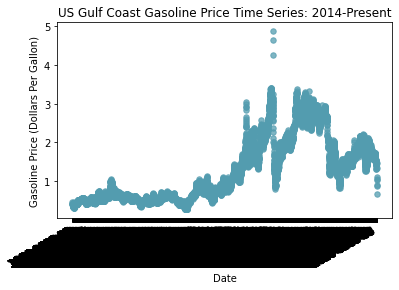

In [0]:
#Visualize anomalies using matplotlib function
scatterplot(gasoline_price_df['Date'],
            gasoline_price_df['Gasoline_Price'], 
            'Date', 
            'Gasoline Price (Dollars Per Gallon)', 
            'US Gulf Coast Gasoline Price Time Series: 2014-Present')

In [0]:
gasoline_price_df.head()

,Date,Gasoline_Price
0,1986 0602 02,0.445
1,1986 0603 03,0.418
2,1986 0604 04,0.398
3,1986 0605 05,0.415
4,1986 0606 06,0.403


In [0]:
gasoline_price_df.tail()

,Date,Gasoline_Price
8505,2020 0310 10,1.107
8506,2020 0311 11,1.035
8507,2020 0312 12,0.873
8508,2020 0313 13,0.907
8509,2020 0316 16,0.657


In [0]:
gasoline_price_df['Date'] = pd.to_datetime(gasoline_price_df['Date'].apply(lambda x: x[:-3]), format="%Y %m%d")
gasoline_price_df['Date']

0      1986-06-02
1      1986-06-03
2      1986-06-04
3      1986-06-05
4      1986-06-06
          ...    
8505   2020-03-10
8506   2020-03-11
8507   2020-03-12
8508   2020-03-13
8509   2020-03-16
Name: Date, Length: 8510, dtype: datetime64[ns]

The period studied in the article comprises from Jan 2014 to 23rd August 2020 (publication date of the article)

In [0]:
gasoline_14_19_df = gasoline_price_df[ (gasoline_price_df['Date'] >= "2014-01-01") \
                                      & (gasoline_price_df['Date'] <= "2019-08-23")] \
                                      .reset_index()

gasoline_14_19_df

,index,Date,Gasoline_Price
0,6939,2014-01-02,2.515
1,6940,2014-01-03,2.493
2,6941,2014-01-06,2.515
3,6942,2014-01-07,2.556
4,6943,2014-01-08,2.545
...,...,...,...
1422,8361,2019-08-19,1.637
1423,8362,2019-08-20,1.653
1424,8363,2019-08-21,1.791
1425,8364,2019-08-22,1.757


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


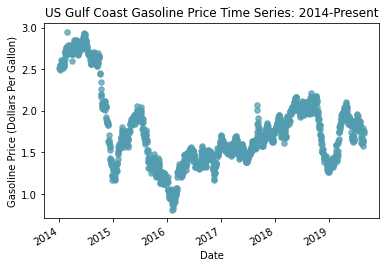

In [0]:
#Visualize anomalies using matplotlib function
scatterplot(gasoline_14_19_df['Date'],
            gasoline_14_19_df['Gasoline_Price'], 
            'Date', 
            'Gasoline Price (Dollars Per Gallon)', 
            'US Gulf Coast Gasoline Price Time Series: 2014-Present')

Adding artificial anomalies

In [0]:
#Add in a couple anomalous data points for detection by the algorithm
anomaly_dictionary={80: 3.1, 
                    200: 3,
                    333: 1,
                    600: 2.6,
                    710: 2.1,
                    890: 2.3,
                    1100: 1,
                    1211: 2.6,
                    1309: 2.3}

#Set default for Artificially_Generated_Anomaly column to 0
gasoline_14_19_df.loc[:,'Artificially_Generated_Anomaly']=0
#Create fake anomaly values based on anomaly_dictionary
for index, anomaly_value in anomaly_dictionary.items():
    gasoline_14_19_df.loc[index,'Gasoline_Price']=anomaly_value
    #Create a column to indicate Anomalies
    gasoline_14_19_df.loc[index,'Artificially_Generated_Anomaly']=1

In [0]:
#Re-visualize data with artificially generated anomalies
scatterplot_with_color_coding(gasoline_14_19_df['Date'],
                              gasoline_14_19_df['Gasoline_Price'], 
                              gasoline_14_19_df['Artificially_Generated_Anomaly'],
                              'Date', 
                              'Gasoline Price (Dollars Per Gallon)', 
                              'Gasoline Prices, Color-Coded on Real/Artificially Generated Data Points')   

NameError: ignored

Seems that the writer forgot to upload this part of the code. However, no worries, we can easily reconstruct it.

In [0]:
def scatterplot_with_color_coding(x_data, y_data, anomaly_flag, x_label, y_label, title):
    """
    Arguments:
        x_data: Series. Desired x-axis for scatterplot.
        y_data: Series. Desired y-axis for scatterplot.
        anomaly_flag: Series. Whether or not a datapoint is considered an anomaly. 1 means anomaly, 0 means normal value.
        x_label: String. Label for x-axis.
        y_label: String. Label for y-axis.
        title: String. Title of plot
    Outputs:
        Scatterplot in console.
    """
    fig, ax = plt.subplots()
    purple="#410454" # Using Gimp on the article
    yellow="#ffe42c"
    colors = anomaly_flag.map({1: yellow, 0: purple})
    ax.scatter(x_data, y_data, s = 30, color = colors, alpha = 0.75)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.autofmt_xdate()

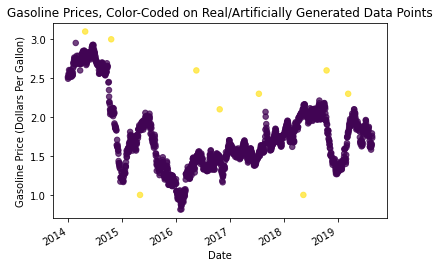

In [0]:
#Re-visualize data with artificially generated anomalies
scatterplot_with_color_coding(gasoline_14_19_df['Date'],
                              gasoline_14_19_df['Gasoline_Price'], 
                              gasoline_14_19_df['Artificially_Generated_Anomaly'],
                              'Date', 
                              'Gasoline Price (Dollars Per Gallon)', 
                              'Gasoline Prices, Color-Coded on Real/Artificially Generated Data Points')  

Now that we have the data properly formated and all the functions ready, let's go with the initial Isolation Forest configuration (for comparison)

In [0]:
def isolation_forest_anomaly_detection(df, 
                                       column_name, 
                                       outliers_fraction):
    """
    In this definition, time series anomalies are detected using an Isolation Forest algorithm.
    Arguments:
        df: Pandas dataframe
        column_name: string. Name of the column that we want to detect anomalies in
        outliers_fraction: float. Percentage of outliers allowed in the sequence.
    Outputs:
        df: Pandas dataframe with column for detected Isolation Forest anomalies (True/False)
    """
    #Scale the column that we want to flag for anomalies
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(df[[column_name]])
    scaled_time_series = pd.DataFrame(np_scaled)
    # train isolation forest 
    model =  IsolationForest(contamination = outliers_fraction, behaviour='new')
    model.fit(scaled_time_series)
    #Generate column for Isolation Forest-detected anomalies
    isolation_forest_anomaly_column = column_name+'_Isolation_Forest_Anomaly'
    df[isolation_forest_anomaly_column] = model.predict(scaled_time_series)
    df[isolation_forest_anomaly_column] = df[isolation_forest_anomaly_column].map( {1: 0, -1: 1} ) # Mapping changed respect to the article
    return df

In [0]:
#APPLY ISOLATION FOREST TO DETECT ANOMALIES
gasoline_price_df=isolation_forest_anomaly_detection(df=gasoline_14_19_df.copy(), 
                                                         column_name='Gasoline_Price', 
                                                         outliers_fraction=.04)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


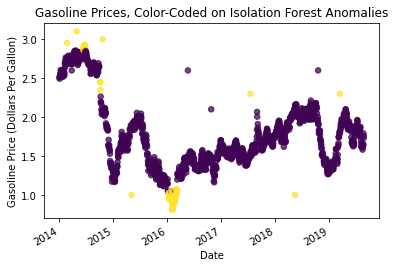

In [0]:
#Re-plot time series with color coding for anomaly column
scatterplot_with_color_coding(gasoline_price_df['Date'],
                                  gasoline_price_df['Gasoline_Price'], 
                                  gasoline_price_df['Gasoline_Price_Isolation_Forest_Anomaly'],
                                  'Date', 
                                  'Gasoline Price (Dollars Per Gallon)', 
                                  'Gasoline Prices, Color-Coded on Isolation Forest Anomalies') 

Let's compare with the ground truth

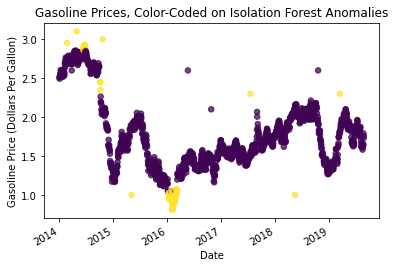

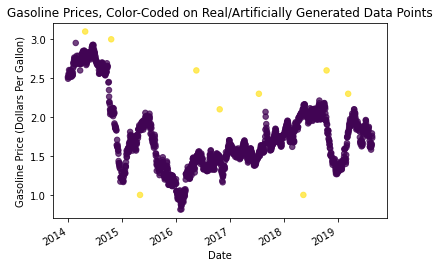

In [0]:
#Re-plot time series with color coding for anomaly column
scatterplot_with_color_coding(gasoline_price_df['Date'],
                                  gasoline_price_df['Gasoline_Price'], 
                                  gasoline_price_df['Gasoline_Price_Isolation_Forest_Anomaly'],
                                  'Date', 
                                  'Gasoline Price (Dollars Per Gallon)', 
                                  'Gasoline Prices, Color-Coded on Isolation Forest Anomalies') 

#Re-visualize data with artificially generated anomalies
scatterplot_with_color_coding(gasoline_14_19_df['Date'],
                              gasoline_14_19_df['Gasoline_Price'], 
                              gasoline_14_19_df['Artificially_Generated_Anomaly'],
                              'Date', 
                              'Gasoline Price (Dollars Per Gallon)', 
                              'Gasoline Prices, Color-Coded on Real/Artificially Generated Data Points')  

This configuration has found 6 out of 9 anomalies. However, it is full of false positives. Let's try something

In [0]:
def isolation_forest_anomaly_detection2(df, 
                                       column_name, 
                                       outliers_fraction):
    """
    In this definition, time series anomalies are detected using an Isolation Forest algorithm.
    This time we add information of the rolling average.
    Arguments:
        df: Pandas dataframe
        column_name: string. Name of the column that we want to detect anomalies in
        outliers_fraction: float. Percentage of outliers allowed in the sequence.
    Outputs:
        df: Pandas dataframe with column for detected Isolation Forest anomalies (True/False)
    """
    #Create 6-value rolling average for gasoline prices
    df['Gasoline_Price_Rolling_Average_6_pt']=df['Gasoline_Price'].rolling(window=6, center=True).mean()
    #Calculate difference between gas price and rolling average value
    df['Gasoline_Price_Diff_From_Rolling_Avg']=df['Gasoline_Price']-df['Gasoline_Price_Rolling_Average_6_pt']

    #Scale the column that we want to flag for anomalies
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(df[column_name])
    scaled_time_series = pd.DataFrame(np_scaled)
    scaled_time_series = scaled_time_series.dropna()
    # train isolation forest 
    model =  IsolationForest(contamination = outliers_fraction, behaviour='new')
    model.fit(scaled_time_series)
    #Generate column for Isolation Forest-detected anomalies
    isolation_forest_anomaly_column = column_name[0] +'_Isolation_Forest_Anomaly'
    scaled_time_series[isolation_forest_anomaly_column] = model.predict(scaled_time_series)
    scaled_time_series[isolation_forest_anomaly_column] = scaled_time_series[isolation_forest_anomaly_column].map( {1: 0, -1: 1} ) # Mapping changed respect to the article
    df[isolation_forest_anomaly_column] = scaled_time_series[isolation_forest_anomaly_column]
    df[isolation_forest_anomaly_column].fillna(0, inplace=True)
    return df

In [0]:
#APPLY ISOLATION FOREST TO DETECT ANOMALIES
gasoline_price_df2=isolation_forest_anomaly_detection2(df=gasoline_14_19_df.copy(), 
                                                         column_name=['Gasoline_Price', 'Gasoline_Price_Diff_From_Rolling_Avg'], 
                                                         outliers_fraction=.04)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


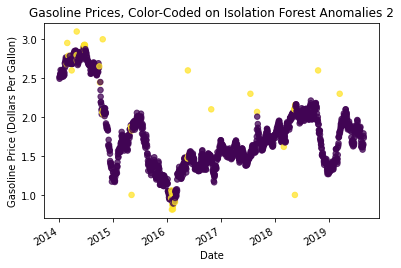

In [0]:
#Re-plot time series with color coding for anomaly column
scatterplot_with_color_coding(gasoline_price_df2['Date'],
                              gasoline_price_df2['Gasoline_Price'], 
                              gasoline_price_df2['Gasoline_Price_Isolation_Forest_Anomaly'],
                              'Date', 
                              'Gasoline Price (Dollars Per Gallon)', 
                              'Gasoline Prices, Color-Coded on Isolation Forest Anomalies 2') 

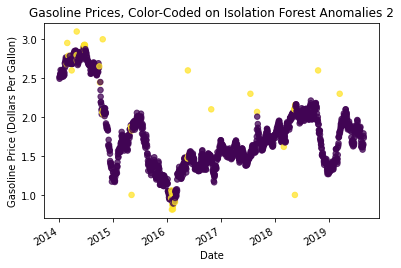

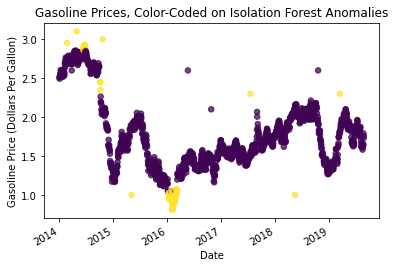

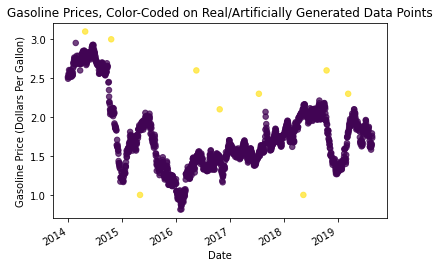

In [0]:
#Re-plot time series with color coding for anomaly column
scatterplot_with_color_coding(gasoline_price_df2['Date'],
                                  gasoline_price_df2['Gasoline_Price'], 
                                  gasoline_price_df2['Gasoline_Price_Isolation_Forest_Anomaly'],
                                  'Date', 
                                  'Gasoline Price (Dollars Per Gallon)', 
                                  'Gasoline Prices, Color-Coded on Isolation Forest Anomalies 2') 

#Re-plot time series with color coding for anomaly column
scatterplot_with_color_coding(gasoline_price_df['Date'],
                                  gasoline_price_df['Gasoline_Price'], 
                                  gasoline_price_df['Gasoline_Price_Isolation_Forest_Anomaly'],
                                  'Date', 
                                  'Gasoline Price (Dollars Per Gallon)', 
                                  'Gasoline Prices, Color-Coded on Isolation Forest Anomalies') 

#Re-visualize data with artificially generated anomalies
scatterplot_with_color_coding(gasoline_14_19_df['Date'],
                              gasoline_14_19_df['Gasoline_Price'], 
                              gasoline_14_19_df['Artificially_Generated_Anomaly'],
                              'Date', 
                              'Gasoline Price (Dollars Per Gallon)', 
                              'Gasoline Prices, Color-Coded on Real/Artificially Generated Data Points')  

This time, all the artificial outliers added to the TS are detected. The total number of false positives seems to be reduced and located at points that fall a bit far from the rolling mean, which could be real outlier. Let's focus only on artifial outliers and compute some metrics

F1 score:  0.2727272727272727


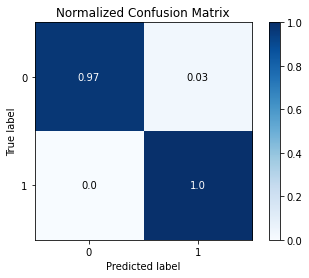

In [0]:
# Model 2 metrics

y = gasoline_14_19_df['Artificially_Generated_Anomaly']
predictions = gasoline_price_df2['Gasoline_Price_Isolation_Forest_Anomaly']
plot_confusion_matrix(y, predictions, normalize=True)
print("F1 score: ", f1_score(y, predictions))

F1 score:  0.17910447761194032


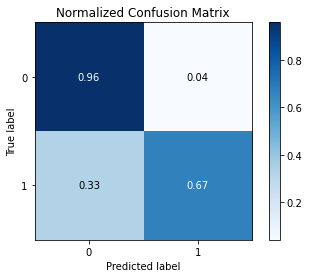

In [0]:
# Model 1 metrics

y = gasoline_14_19_df['Artificially_Generated_Anomaly']
predictions = gasoline_price_df['Gasoline_Price_Isolation_Forest_Anomaly']
plot_confusion_matrix(y, predictions, normalize=True)
print("F1 score: ", f1_score(y, predictions))

Hyphotesis confirmed!!